In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Data paths
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
CROSS1_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
CROSS2_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
CROSS3_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test3")

# Helper functions
def extract_label_from_filename(filename):
    """Extract task label from filename"""
    parts = os.path.basename(filename).split('_')
    if parts[0] == 'rest':
        return 'rest'
    else:
        return '_'.join(parts[:2])  # For tasks like 'task_motor', 'task_story_math'

def load_and_process_file(filepath):
    """Load a single HDF5 file and return the data matrix"""
    with h5py.File(filepath, 'r') as h5file:
        # Get the first (and only) key in the file
        key = list(h5file.keys())[0]
        matrix = h5file[key][:]
    return matrix

def load_dataset(folder_path):
    """Load all files from a folder and return as X, y"""
    X = []
    y = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    
    for filename in tqdm(filenames, desc=f"Loading {os.path.basename(folder_path)}"):
        filepath = os.path.join(folder_path, filename)
        try:
            matrix = load_and_process_file(filepath)
            
            # Flatten the matrix (248 timepoints × 35624 features)
            flattened = matrix.reshape(matrix.shape[0], -1)  # Keep samples separate
            X.append(flattened)
            
            label = extract_label_from_filename(filename)
            y.extend([label] * matrix.shape[0])  # One label per timepoint
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue
    
    # Concatenate all matrices
    X = np.concatenate(X, axis=0) if X else np.array([])
    y = np.array(y)
    
    return X, y

# Load training data
print("Loading training data...")
X_train, y_train = load_dataset(CROSS_TRAIN_FOLDER)

# Load test data
print("\nLoading test data...")
X_test1, y_test1 = load_dataset(CROSS1_TEST_FOLDER)
X_test2, y_test2 = load_dataset(CROSS2_TEST_FOLDER)
X_test3, y_test3 = load_dataset(CROSS3_TEST_FOLDER)

# Check if we have data
if X_train.size == 0 or X_test1.size == 0 or X_test2.size == 0 or X_test3.size == 0:
    raise ValueError("No data loaded. Check file paths and contents.")

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test1_encoded = label_encoder.transform(y_test1)
y_test2_encoded = label_encoder.transform(y_test2)
y_test3_encoded = label_encoder.transform(y_test3)

# Print class distribution
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts())

# Dimensionality reduction - necessary due to high dimensionality
print("\nApplying PCA for dimensionality reduction...")
pca = PCA(n_components=100)  # Reduce to 100 components (can adjust this)
X_train_pca = pca.fit_transform(X_train)
X_test1_pca = pca.transform(X_test1)
X_test2_pca = pca.transform(X_test2)
X_test3_pca = pca.transform(X_test3)

# Train a classifier
print("\nTraining classifier...")
# Using a pipeline with standardization and SVM
model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
)

model.fit(X_train_pca, y_train_encoded)

# Evaluate on training set
train_pred = model.predict(X_train_pca)
train_acc = accuracy_score(y_train_encoded, train_pred)
print(f"\nTraining accuracy: {train_acc:.2f}")

# Evaluate on test sets
def evaluate_on_test(X_test, y_test, test_name):
    print(f"\nEvaluating on {test_name}:")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(label_encoder.inverse_transform(y_test), 
                     label_encoder.inverse_transform(y_pred),
                     rownames=['True'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {test_name}')
    plt.show()

evaluate_on_test(X_test1_pca, y_test1_encoded, "Test Set 1")
evaluate_on_test(X_test2_pca, y_test2_encoded, "Test Set 2")
evaluate_on_test(X_test3_pca, y_test3_encoded, "Test Set 3")

# Improved of above

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)

# Data paths
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
CROSS1_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
CROSS2_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
CROSS3_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test3")

# Helper functions
def extract_label_from_filename(filename):
    """Extract task label from filename"""
    parts = os.path.basename(filename).split('_')
    if parts[0] == 'rest':
        return 'rest'
    else:
        return '_'.join(parts[:2])  # For tasks like 'task_motor', 'task_story_math'

def load_and_process_file(filepath):
    """Load a single HDF5 file and return the data matrix"""
    with h5py.File(filepath, 'r') as h5file:
        key = list(h5file.keys())[0]
        matrix = h5file[key][:]
    return matrix

def extract_features(matrix):
    """Extract time-series features from MEG data"""
    # Select a subset of channels (reduce dimensionality)
    num_channels = min(100, matrix.shape[1])  # Use first 100 channels or all if <100
    matrix = matrix[:, :num_channels]
    
    # Bandpass filter (0.5-40 Hz)
    fs = 2034  # Sampling frequency
    b, a = signal.butter(4, [0.5, 40], btype='bandpass', fs=fs)
    filtered = signal.filtfilt(b, a, matrix, axis=0)
    
    # Time-frequency features
    freqs, psd = signal.welch(filtered, fs=fs, nperseg=256)
    
    # Statistical features
    means = np.mean(filtered, axis=0)
    stds = np.std(filtered, axis=0)
    maxs = np.max(filtered, axis=0)
    mins = np.min(filtered, axis=0)
    
    # Concatenate all features
    features = np.concatenate([
        means, stds, maxs, mins,
        psd.mean(axis=0), psd.std(axis=0)
    ])
    
    return features

def load_dataset(folder_path, per_file=True):
    """Load all files from a folder and return as X, y"""
    X = []
    y = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    
    for filename in tqdm(filenames, desc=f"Loading {os.path.basename(folder_path)}"):
        filepath = os.path.join(folder_path, filename)
        try:
            matrix = load_and_process_file(filepath)
            label = extract_label_from_filename(filename)
            
            if per_file:
                # Extract features per file (one sample per file)
                features = extract_features(matrix)
                X.append(features)
                y.append(label)
            else:
                # Extract features per time window (multiple samples per file)
                # Split into overlapping windows
                window_size = 500  # ~0.25s windows
                step = 250  # 50% overlap
                for i in range(0, matrix.shape[0] - window_size, step):
                    window = matrix[i:i+window_size]
                    features = extract_features(window)
                    X.append(features)
                    y.append(label)
                    
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue
    
    X = np.array(X) if X else np.array([])
    y = np.array(y)
    
    return X, y

# Load training data (one sample per file)
print("Loading training data...")
X_train, y_train = load_dataset(CROSS_TRAIN_FOLDER, per_file=True)

# Load test data
print("\nLoading test data...")
X_test1, y_test1 = load_dataset(CROSS1_TEST_FOLDER, per_file=True)
X_test2, y_test2 = load_dataset(CROSS2_TEST_FOLDER, per_file=True)
X_test3, y_test3 = load_dataset(CROSS3_TEST_FOLDER, per_file=True)

# Check if we have data
if X_train.size == 0 or X_test1.size == 0 or X_test2.size == 0 or X_test3.size == 0:
    raise ValueError("No data loaded. Check file paths and contents.")

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test1_encoded = label_encoder.transform(y_test1)
y_test2_encoded = label_encoder.transform(y_test2)
y_test3_encoded = label_encoder.transform(y_test3)

# Print class distribution
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts())

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)
X_test3_scaled = scaler.transform(X_test3)

# Option 1: Random Forest Classifier
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, 
                                max_depth=15, 
                                random_state=42,
                                class_weight='balanced')
rf_model.fit(X_train_scaled, y_train_encoded)

# Evaluate RF
def evaluate_model(model, X_test, y_test, test_name):
    print(f"\nEvaluating on {test_name}:")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(label_encoder.inverse_transform(y_test), 
                     label_encoder.inverse_transform(y_pred),
                     rownames=['True'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {test_name}')
    plt.show()

print("\nRandom Forest Results:")
evaluate_model(rf_model, X_test1_scaled, y_test1_encoded, "Test Set 1")
evaluate_model(rf_model, X_test2_scaled, y_test2_encoded, "Test Set 2")
evaluate_model(rf_model, X_test3_scaled, y_test3_encoded, "Test Set 3")

# Option 2: Neural Network (if you want to try deep learning)
print("\nTraining Neural Network...")
num_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_test1_categorical = to_categorical(y_test1_encoded, num_classes)
y_test2_categorical = to_categorical(y_test2_encoded, num_classes)
y_test3_categorical = to_categorical(y_test3_encoded, num_classes)

nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

nn_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train_categorical, test_size=0.2, random_state=42)

history = nn_model.fit(X_train_split, y_train_split,
                     epochs=100,
                     batch_size=32,
                     validation_data=(X_val_split, y_val_split),
                     callbacks=[early_stop],
                     verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

# Evaluate NN
print("\nNeural Network Results:")
def evaluate_nn(model, X_test, y_test, test_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    acc = accuracy_score(y_true_classes, y_pred_classes)
    print(f"\nEvaluating on {test_name}:")
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, 
                               target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(label_encoder.inverse_transform(y_true_classes), 
                     label_encoder.inverse_transform(y_pred_classes),
                     rownames=['True'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {test_name}')
    plt.show()

evaluate_nn(nn_model, X_test1_scaled, y_test1_categorical, "Test Set 1")
evaluate_nn(nn_model, X_test2_scaled, y_test2_categorical, "Test Set 2")
evaluate_nn(nn_model, X_test3_scaled, y_test3_categorical, "Test Set 3")

# Improvement on above

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import mne
from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

# Set random seed for reproducibility
np.random.seed(42)

# Data paths
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
CROSS1_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
CROSS2_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
CROSS3_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test3")

# Helper functions
def extract_label_from_filename(filename):
    """Extract task label from filename"""
    parts = os.path.basename(filename).split('_')
    if parts[0] == 'rest':
        return 'rest'
    else:
        return '_'.join(parts[:2])

def load_and_process_file(filepath):
    """Load a single HDF5 file and return the data matrix"""
    with h5py.File(filepath, 'r') as h5file:
        key = list(h5file.keys())[0]
        matrix = h5file[key][:]
    return matrix

def extract_advanced_features(matrix, fs=2034):
    """Extract comprehensive time-series features from MEG data"""
    num_channels = min(100, matrix.shape[1])  # Use first 100 channels
    
    # Preprocessing
    b, a = signal.butter(4, [0.5, 40], btype='bandpass', fs=fs)
    filtered = signal.filtfilt(b, a, matrix[:, :num_channels], axis=0)
    
    # Time-domain features
    means = np.mean(filtered, axis=0)
    stds = np.std(filtered, axis=0)
    skews = stats.skew(filtered, axis=0)
    kurtoses = stats.kurtosis(filtered, axis=0)
    maxs = np.max(filtered, axis=0)
    mins = np.min(filtered, axis=0)
    ranges = maxs - mins
    
    # Frequency-domain features
    freqs, psd = signal.welch(filtered, fs=fs, nperseg=min(256, filtered.shape[0]))
    psd_mean = np.mean(psd, axis=0)
    psd_std = np.std(psd, axis=0)
    psd_max = np.max(psd, axis=0)
    psd_ratio = psd_max / (psd_mean + 1e-10)
    
    # Connectivity features (simplified)
    corr = np.corrcoef(filtered.T)
    upper_tri = corr[np.triu_indices_from(corr, k=1)]
    
    # Hjorth parameters
    def hjorth_params(x):
        diff1 = np.diff(x, axis=0)
        diff2 = np.diff(diff1, axis=0)
        var0 = np.var(x, axis=0)
        var1 = np.var(diff1, axis=0)
        var2 = np.var(diff2, axis=0)
        activity = var0
        mobility = np.sqrt(var1 / var0)
        complexity = np.sqrt(var2 / var1) / mobility
        return activity, mobility, complexity
    
    hjorth_activity, hjorth_mobility, hjorth_complexity = hjorth_params(filtered)
    
    # Concatenate all features
    features = np.concatenate([
        means, stds, skews, kurtoses, maxs, mins, ranges,
        psd_mean, psd_std, psd_max, psd_ratio,
        hjorth_activity, hjorth_mobility, hjorth_complexity,
        upper_tri
    ])
    
    return features

def create_mne_epochs(matrix, fs=2034):
    """Create MNE Epochs object for CSP"""
    info = mne.create_info(matrix.shape[1], sfreq=fs, ch_types='mag')
    raw = mne.io.RawArray(matrix.T, info)
    events = np.array([[0, 0, 1]])
    epochs = mne.Epochs(raw, events, tmin=0, tmax=matrix.shape[0]/fs-1/fs, baseline=None)
    return epochs

def load_dataset(folder_path):
    """Load all files from a folder and return as X, y with advanced features"""
    X = []
    y = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    
    for filename in tqdm(filenames, desc=f"Loading {os.path.basename(folder_path)}"):
        filepath = os.path.join(folder_path, filename)
        try:
            matrix = load_and_process_file(filepath)
            label = extract_label_from_filename(filename)
            
            # Extract advanced features
            features = extract_advanced_features(matrix)
            X.append(features)
            y.append(label)
            
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue
    
    return np.array(X), np.array(y)

# Load datasets
print("Loading training data...")
X_train, y_train = load_dataset(CROSS_TRAIN_FOLDER)
print("\nLoading test data...")
X_test1, y_test1 = load_dataset(CROSS1_TEST_FOLDER)
X_test2, y_test2 = load_dataset(CROSS2_TEST_FOLDER)
X_test3, y_test3 = load_dataset(CROSS3_TEST_FOLDER)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test1_encoded = label_encoder.transform(y_test1)
y_test2_encoded = label_encoder.transform(y_test2)
y_test3_encoded = label_encoder.transform(y_test3)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)
X_test3_scaled = scaler.transform(X_test3)

# Ensemble Model with Stacking
print("\nTraining Ensemble Classifier...")

# Base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=300, 
                                 max_depth=20, 
                                 class_weight='balanced',
                                 random_state=42)),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', 
                probability=True, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, 
                          max_depth=5, 
                          learning_rate=0.1,
                          random_state=42))
]

# Final estimator
final_estimator = XGBClassifier(n_estimators=100, 
                               max_depth=3, 
                               learning_rate=0.05,
                               random_state=42)

# Create stacked model
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    stack_method='predict_proba'
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacked_model, X_train_scaled, y_train_encoded, 
                          cv=cv, scoring='accuracy')
print(f"\nCross-validation accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Train on full training set
stacked_model.fit(X_train_scaled, y_train_encoded)

# Evaluation function
def evaluate_model(model, X_test, y_test, test_name):
    print(f"\nEvaluating on {test_name}:")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(label_encoder.inverse_transform(y_test), 
                     label_encoder.inverse_transform(y_pred),
                     rownames=['True'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {test_name}')
    plt.show()

# Evaluate
print("\nEnsemble Model Results:")
evaluate_model(stacked_model, X_test1_scaled, y_test1_encoded, "Test Set 1")
evaluate_model(stacked_model, X_test2_scaled, y_test2_encoded, "Test Set 2")
evaluate_model(stacked_model, X_test3_scaled, y_test3_encoded, "Test Set 3")

# Optional: CSP-based approach (if you want to try)
print("\nTrying CSP-based approach...")
def load_data_for_csp(folder_path):
    X = []
    y = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    
    for filename in filenames:
        filepath = os.path.join(folder_path, filename)
        try:
            matrix = load_and_process_file(filepath)
            label = extract_label_from_filename(filename)
            
            # Use first 100 channels and downsample to make it manageable
            matrix = matrix[:, :100]
            matrix = signal.resample(matrix, 500, axis=0)  # Downsample to 500 timepoints
            
            X.append(matrix.T)  # CSP expects shape (n_channels, n_samples)
            y.append(label)
            
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue
    
    return X, np.array(y)

# Load data for CSP
X_train_csp, y_train_csp = load_data_for_csp(CROSS_TRAIN_FOLDER)
X_test1_csp, y_test1_csp = load_data_for_csp(CROSS1_TEST_FOLDER)

# Encode labels
y_train_csp_encoded = label_encoder.transform(y_train_csp)
y_test1_csp_encoded = label_encoder.transform(y_test1_csp)

# CSP Pipeline
csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
clf = SVC(kernel='linear', C=1.0)

# Create pipeline
csp_pipeline = make_pipeline(csp, clf)

# Train and evaluate
csp_pipeline.fit(X_train_csp, y_train_csp_encoded)
y_pred_csp = csp_pipeline.predict(X_test1_csp)
print("\nCSP-SVM Accuracy:", accuracy_score(y_test1_csp_encoded, y_pred_csp))
print(classification_report(y_test1_csp_encoded, y_pred_csp, target_names=label_encoder.classes_))

# Above is ok for two test sets, but erros later do different approach

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats

# Set random seed for reproducibility
np.random.seed(42)

# Data paths
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
CROSS1_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
CROSS2_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
CROSS3_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test3")

# Helper functions
def extract_label_from_filename(filename):
    """Extract task label from filename"""
    parts = os.path.basename(filename).split('_')
    if parts[0] == 'rest':
        return 'rest'
    else:
        return '_'.join(parts[:2])

def load_and_process_file(filepath):
    """Load a single HDF5 file and return the data matrix"""
    with h5py.File(filepath, 'r') as h5file:
        key = list(h5file.keys())[0]
        matrix = h5file[key][:]
    return matrix

def extract_safe_features(matrix, fs=2034):
    """Extract features with proper error handling"""
    try:
        num_channels = min(100, matrix.shape[1])  # Use first 100 channels
        
        # Time-domain features (no filtering to avoid errors)
        means = np.mean(matrix[:, :num_channels], axis=0)
        stds = np.std(matrix[:, :num_channels], axis=0)
        maxs = np.max(matrix[:, :num_channels], axis=0)
        mins = np.min(matrix[:, :num_channels], axis=0)
        ranges = maxs - mins
        
        # Simple frequency features (no Welch to avoid errors)
        fft = np.abs(np.fft.fft(matrix[:, :num_channels], axis=0))
        fft_mean = np.mean(fft, axis=0)
        fft_std = np.std(fft, axis=0)
        
        # Cross-channel correlation
        corr = np.corrcoef(matrix[:, :num_channels].T)
        upper_tri = corr[np.triu_indices_from(corr, k=1)]
        
        # Concatenate all features
        features = np.concatenate([
            means, stds, maxs, mins, ranges,
            fft_mean, fft_std,
            upper_tri
        ])
        
        return features
    except Exception as e:
        print(f"Feature extraction error: {str(e)}")
        return None

def load_dataset(folder_path):
    """Load all files from a folder and return as X, y"""
    X = []
    y = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    
    for filename in tqdm(filenames, desc=f"Loading {os.path.basename(folder_path)}"):
        filepath = os.path.join(folder_path, filename)
        try:
            matrix = load_and_process_file(filepath)
            label = extract_label_from_filename(filename)
            
            features = extract_safe_features(matrix)
            if features is not None:
                X.append(features)
                y.append(label)
            
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue
    
    return np.array(X), np.array(y)

# Load datasets
print("Loading training data...")
X_train, y_train = load_dataset(CROSS_TRAIN_FOLDER)
print("\nLoading test data...")
X_test1, y_test1 = load_dataset(CROSS1_TEST_FOLDER)
X_test2, y_test2 = load_dataset(CROSS2_TEST_FOLDER)
X_test3, y_test3 = load_dataset(CROSS3_TEST_FOLDER)

# Check if we got any data
if len(X_train) == 0 or len(X_test1) == 0 or len(X_test2) == 0 or len(X_test3) == 0:
    raise ValueError("No data was successfully loaded. Check the feature extraction.")

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test1_encoded = label_encoder.transform(y_test1)
y_test2_encoded = label_encoder.transform(y_test2)
y_test3_encoded = label_encoder.transform(y_test3)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)
X_test3_scaled = scaler.transform(X_test3)

# Dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test1_pca = pca.transform(X_test1_scaled)
X_test2_pca = pca.transform(X_test2_scaled)
X_test3_pca = pca.transform(X_test3_scaled)

# Optimized Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_pca, y_train_encoded, 
                          cv=cv, scoring='accuracy')
print(f"\nCross-validation accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Train on full training set
rf_model.fit(X_train_pca, y_train_encoded)

# Evaluation function
def evaluate_model(model, X_test, y_test, test_name):
    print(f"\nEvaluating on {test_name}:")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(label_encoder.inverse_transform(y_test), 
                     label_encoder.inverse_transform(y_pred),
                     rownames=['True'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {test_name}')
    plt.show()

# Evaluate
print("\nRandom Forest Results:")
evaluate_model(rf_model, X_test1_pca, y_test1_encoded, "Test Set 1")
evaluate_model(rf_model, X_test2_pca, y_test2_encoded, "Test Set 2")
evaluate_model(rf_model, X_test3_pca, y_test3_encoded, "Test Set 3")

# Alternative SVM Classifier
print("\nTraining SVM Classifier...")
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, gamma='scale', 
        class_weight='balanced', random_state=42)
)

svm_model.fit(X_train_pca, y_train_encoded)

print("\nSVM Results:")
evaluate_model(svm_model, X_test1_pca, y_test1_encoded, "Test Set 1")
evaluate_model(svm_model, X_test2_pca, y_test2_encoded, "Test Set 2")
evaluate_model(svm_model, X_test3_pca, y_test3_encoded, "Test Set 3")

# The above adapted to deep learning

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Data paths
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
CROSS1_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
CROSS2_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
CROSS3_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test3")

# Helper functions
def extract_label_from_filename(filename):
    """Extract task label from filename"""
    parts = os.path.basename(filename).split('_')
    if parts[0] == 'rest':
        return 'rest'
    else:
        return '_'.join(parts[:2])

def load_and_process_file(filepath):
    """Load a single HDF5 file and return the data matrix"""
    with h5py.File(filepath, 'r') as h5file:
        key = list(h5file.keys())[0]
        matrix = h5file[key][:]
    return matrix

def extract_safe_features(matrix, fs=2034):
    """Extract features with proper error handling"""
    try:
        num_channels = min(100, matrix.shape[1])  # Use first 100 channels
        
        # Time-domain features (no filtering to avoid errors)
        means = np.mean(matrix[:, :num_channels], axis=0)
        stds = np.std(matrix[:, :num_channels], axis=0)
        maxs = np.max(matrix[:, :num_channels], axis=0)
        mins = np.min(matrix[:, :num_channels], axis=0)
        ranges = maxs - mins
        
        # Simple frequency features (no Welch to avoid errors)
        fft = np.abs(np.fft.fft(matrix[:, :num_channels], axis=0))
        fft_mean = np.mean(fft, axis=0)
        fft_std = np.std(fft, axis=0)
        
        # Cross-channel correlation
        corr = np.corrcoef(matrix[:, :num_channels].T)
        upper_tri = corr[np.triu_indices_from(corr, k=1)]
        
        # Concatenate all features
        features = np.concatenate([
            means, stds, maxs, mins, ranges,
            fft_mean, fft_std,
            upper_tri
        ])
        
        return features
    except Exception as e:
        print(f"Feature extraction error: {str(e)}")
        return None

def load_dataset(folder_path):
    """Load all files from a folder and return as X, y"""
    X = []
    y = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    
    for filename in tqdm(filenames, desc=f"Loading {os.path.basename(folder_path)}"):
        filepath = os.path.join(folder_path, filename)
        try:
            matrix = load_and_process_file(filepath)
            label = extract_label_from_filename(filename)
            
            features = extract_safe_features(matrix)
            if features is not None:
                X.append(features)
                y.append(label)
            
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue
    
    return np.array(X), np.array(y)

# Load datasets
print("Loading training data...")
X_train, y_train = load_dataset(CROSS_TRAIN_FOLDER)
print("\nLoading test data...")
X_test1, y_test1 = load_dataset(CROSS1_TEST_FOLDER)
X_test2, y_test2 = load_dataset(CROSS2_TEST_FOLDER)
X_test3, y_test3 = load_dataset(CROSS3_TEST_FOLDER)

# Check if we got any data
if len(X_train) == 0 or len(X_test1) == 0 or len(X_test2) == 0 or len(X_test3) == 0:
    raise ValueError("No data was successfully loaded. Check the feature extraction.")

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test1_encoded = label_encoder.transform(y_test1)
y_test2_encoded = label_encoder.transform(y_test2)
y_test3_encoded = label_encoder.transform(y_test3)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)
X_test3_scaled = scaler.transform(X_test3)

# Dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test1_pca = pca.transform(X_test1_scaled)
X_test2_pca = pca.transform(X_test2_scaled)
X_test3_pca = pca.transform(X_test3_scaled)

# Set random seeds for reproducibility


# [Keep all your existing data loading and preprocessing code until X_train_pca]

# Deep Neural Network Architecture
def create_dnn_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,), 
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Enhanced DNN Architecture with more robust regularization
# def create_improved_dnn(input_shape, num_classes):
#     model = Sequential([
#         Dense(512, activation='swish', input_shape=(input_shape,),
#               kernel_regularizer=l2(0.01)),
#         BatchNormalization(),
#         Dropout(0.6),
        
#         Dense(256, activation='swish', kernel_regularizer=l2(0.01)),
#         BatchNormalization(),
#         Dropout(0.5),
        
#         Dense(128, activation='swish', kernel_regularizer=l2(0.005)),
#         BatchNormalization(),
#         Dropout(0.4),
        
#         Dense(num_classes, activation='softmax')
#     ])
    
#     optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
#     model.compile(optimizer=optimizer,
#                  loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])
#     return model

# Create validation split from training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pca, y_train_encoded, test_size=0.15, stratify=y_train_encoded, random_state=42
)

# Model parameters
input_shape = X_train_pca.shape[1]
num_classes = len(label_encoder.classes_)

# Create and train model
model = create_dnn_model(input_shape, num_classes)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Train the model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Modified evaluation function for DNN
def evaluate_dnn_model(model, X_test, y_test, test_name):
    print(f"\nEvaluating on {test_name}:")
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(label_encoder.inverse_transform(y_test), 
                     label_encoder.inverse_transform(y_pred),
                     rownames=['True'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {test_name}')
    plt.show()

# Evaluate
print("\nDeep Neural Network Results:")
evaluate_dnn_model(model, X_test1_pca, y_test1_encoded, "Test Set 1")
evaluate_dnn_model(model, X_test2_pca, y_test2_encoded, "Test Set 2")
evaluate_dnn_model(model, X_test3_pca, y_test3_encoded, "Test Set 3")

# Same as above but, improved here and there

Loading training data...


Loading train: 100%|██████████| 64/64 [00:04<00:00, 13.72it/s]



Loading test data...


Loading test3: 100%|██████████| 16/16 [00:01<00:00, 10.38it/s]


Epoch 1/200


c:\Users\Daan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2593 - loss: 6.4714 - val_accuracy: 0.6000 - val_loss: 5.5386 - learning_rate: 1.0000e-04
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2778 - loss: 6.7443 - val_accuracy: 0.5000 - val_loss: 5.5056 - learning_rate: 1.0000e-04
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2963 - loss: 6.3774 - val_accuracy: 0.6000 - val_loss: 5.4754 - learning_rate: 1.0000e-04
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4630 - loss: 5.8450 - val_accuracy: 0.6000 - val_loss: 5.4462 - learning_rate: 1.0000e-04
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3704 - loss: 6.3513 - val_accuracy: 0.6000 - val_loss: 5.4190 - learning_rate: 1.0000e-04
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2963 - loss: 6.2360 - val_accuracy: 0.6000 - val_loss: 5.3892 - learning_rate: 1.0000e-04
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3519 - loss: 6.7539 

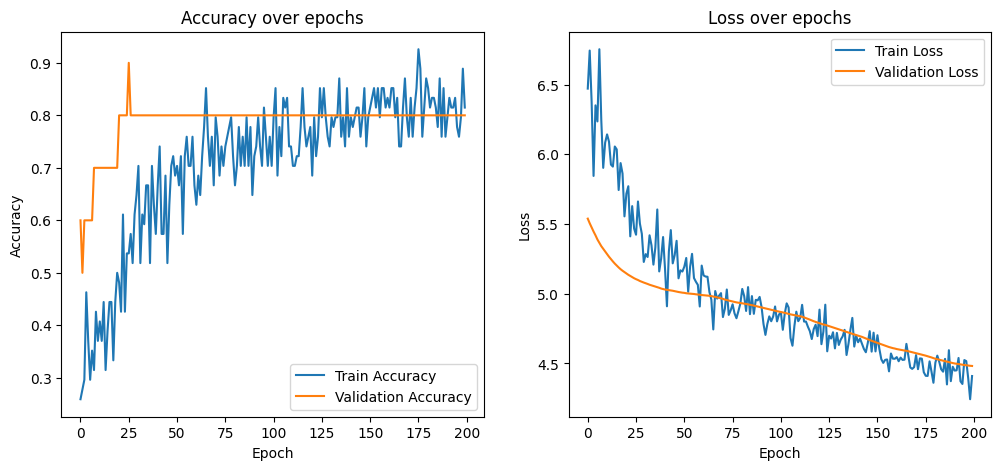


Deep Neural Network Results:

Evaluating on Test Set 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

        rest       1.00      0.75      0.86         4
  task_motor       0.60      0.75      0.67         4
  task_story       0.80      1.00      0.89         4
task_working       0.67      0.50      0.57         4

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16



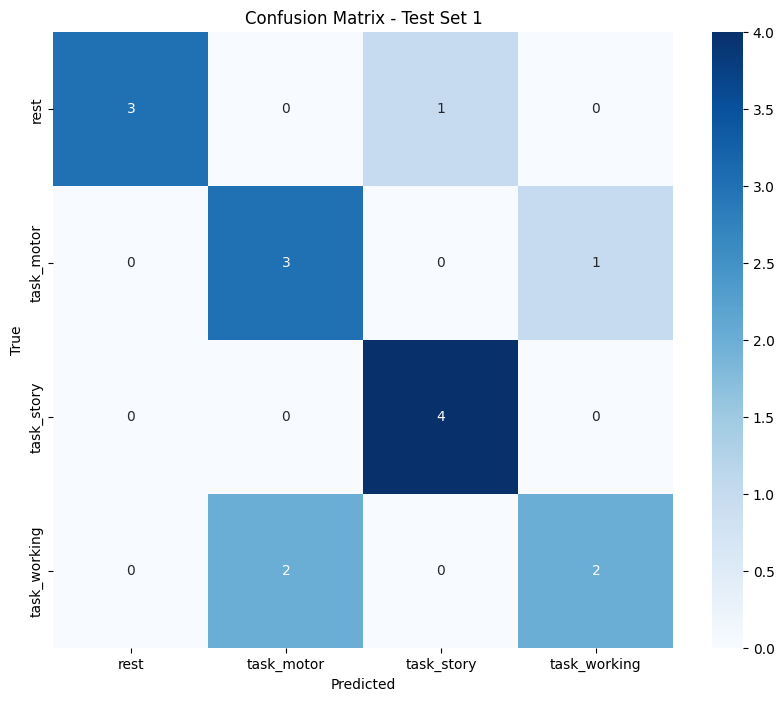


Evaluating on Test Set 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Accuracy: 0.25

Classification Report:
              precision    recall  f1-score   support

        rest       1.00      1.00      1.00         4
  task_motor       0.00      0.00      0.00         4
  task_story       0.00      0.00      0.00         4
task_working       0.00      0.00      0.00         4

    accuracy                           0.25        16
   macro avg       0.25      0.25      0.25        16
weighted avg       0.25      0.25      0.25        16



c:\Users\Daan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Daan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Daan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

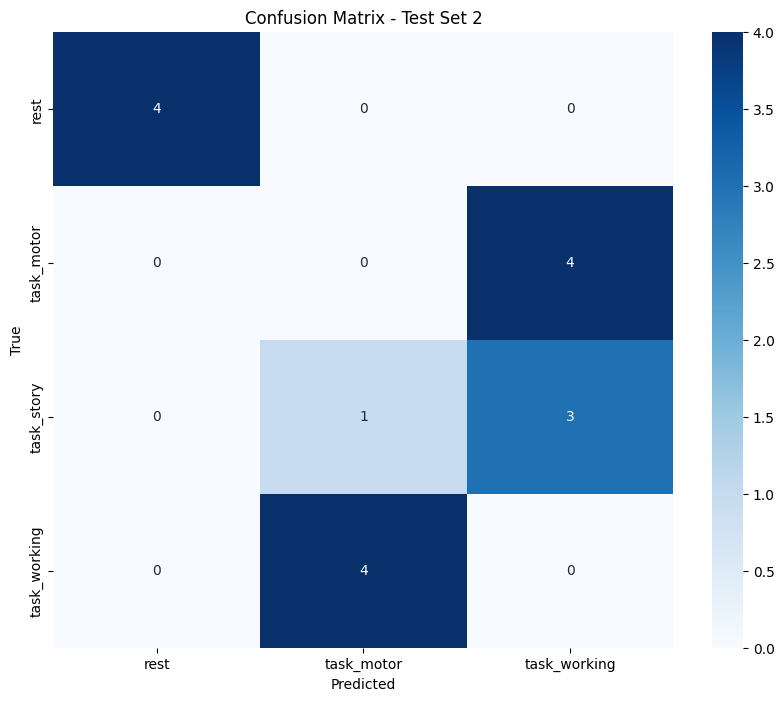


Evaluating on Test Set 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

        rest       0.67      1.00      0.80         4
  task_motor       0.50      0.50      0.50         4
  task_story       1.00      0.25      0.40         4
task_working       0.80      1.00      0.89         4

    accuracy                           0.69        16
   macro avg       0.74      0.69      0.65        16
weighted avg       0.74      0.69      0.65        16



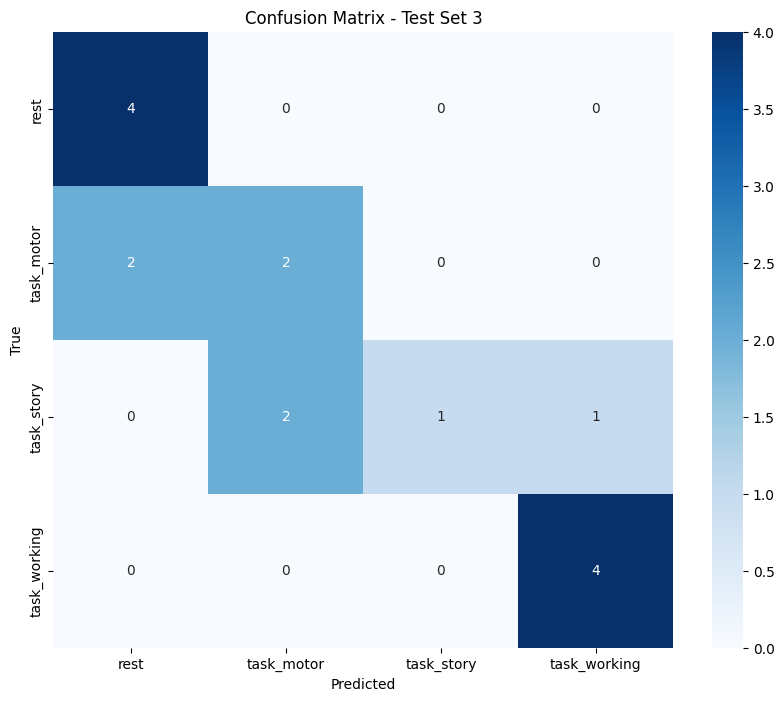


Evaluating with Test Time Augmentation:

Evaluating on Test Set 1 with TTA:
Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

        rest       1.00      0.75      0.86         4
  task_motor       0.60      0.75      0.67         4
  task_story       0.80      1.00      0.89         4
task_working       0.67      0.50      0.57         4

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16



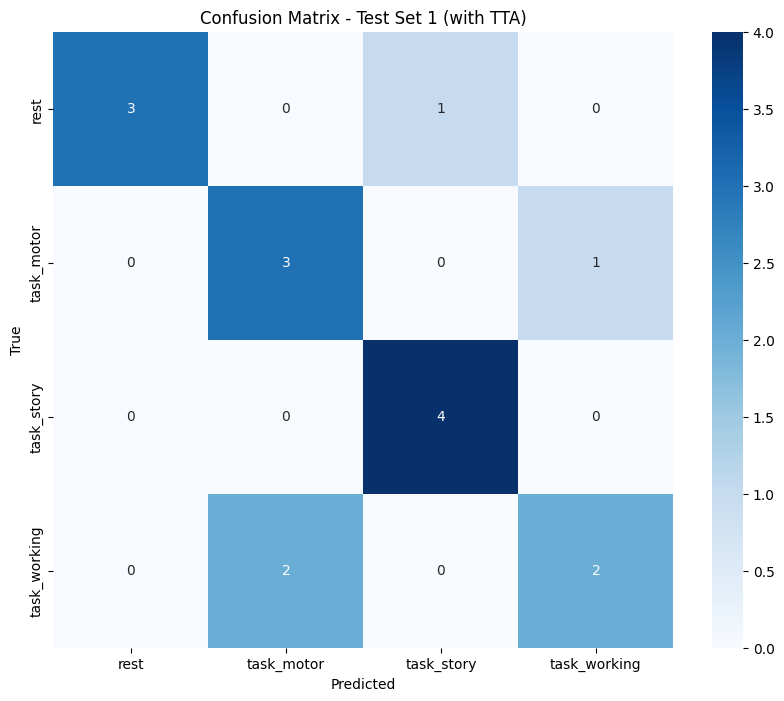


Evaluating on Test Set 2 with TTA:
Accuracy: 0.25

Classification Report:
              precision    recall  f1-score   support

        rest       1.00      1.00      1.00         4
  task_motor       0.00      0.00      0.00         4
  task_story       0.00      0.00      0.00         4
task_working       0.00      0.00      0.00         4

    accuracy                           0.25        16
   macro avg       0.25      0.25      0.25        16
weighted avg       0.25      0.25      0.25        16



c:\Users\Daan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Daan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Daan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

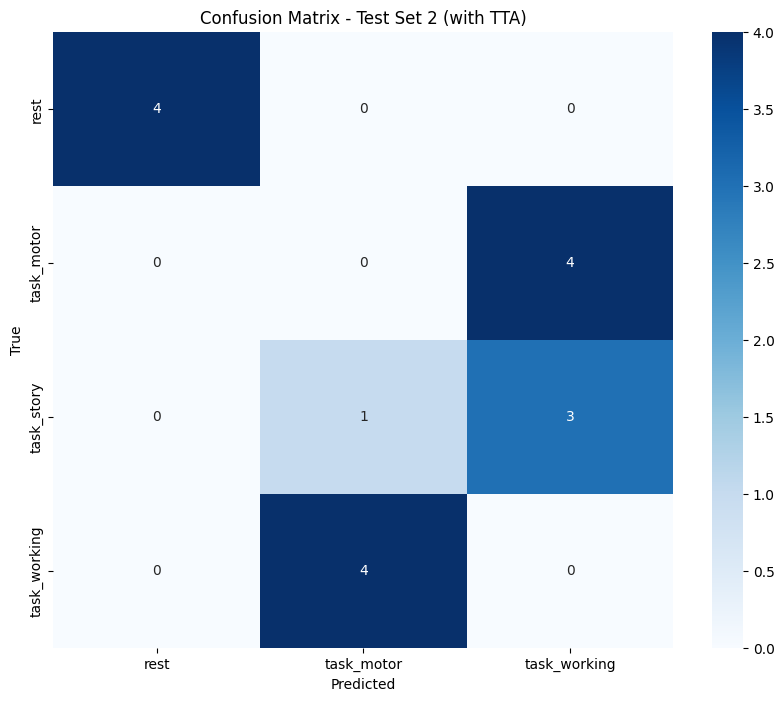


Evaluating on Test Set 3 with TTA:
Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

        rest       0.67      1.00      0.80         4
  task_motor       0.50      0.50      0.50         4
  task_story       1.00      0.25      0.40         4
task_working       0.80      1.00      0.89         4

    accuracy                           0.69        16
   macro avg       0.74      0.69      0.65        16
weighted avg       0.74      0.69      0.65        16



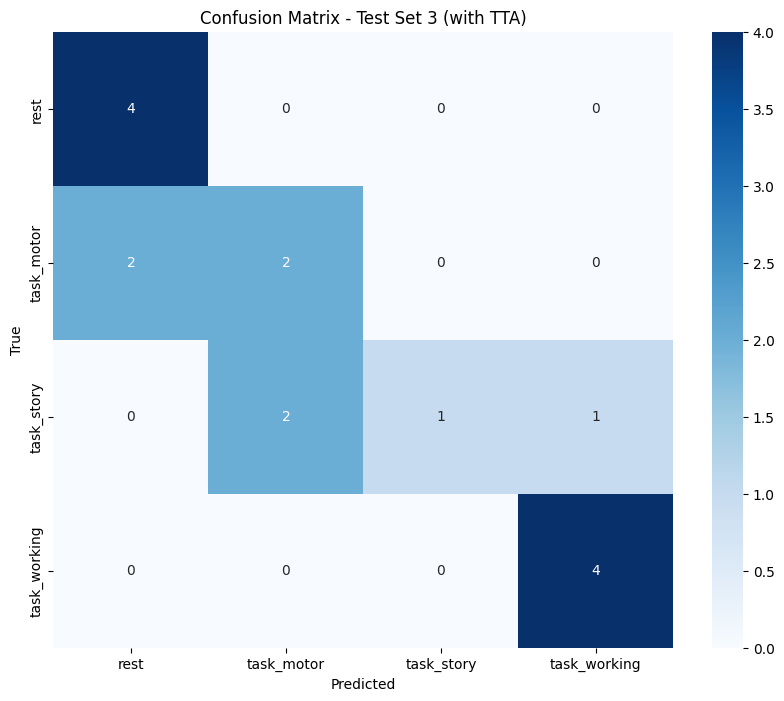

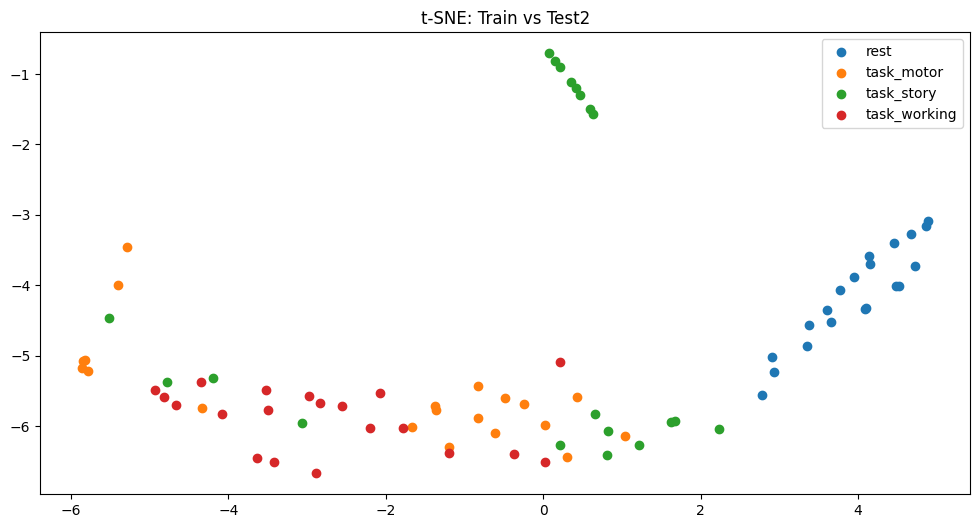


Training model 1/3


c:\Users\Daan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training model 2/3

Training model 3/3


In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE

# Set random seed for reproducibility
# np.random.seed(42)
# tf.random.set_seed(42)

# Data paths
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
CROSS1_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
CROSS2_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
CROSS3_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test3")

# Helper functions
def extract_label_from_filename(filename):
    """Extract task label from filename"""
    parts = os.path.basename(filename).split('_')
    if parts[0] == 'rest':
        return 'rest'
    else:
        return '_'.join(parts[:2])
    
def plot_tsne(X_sets, y_sets, labels, title):
    X_all = np.vstack(X_sets)
    y_all = np.concatenate(y_sets)
    tsne = TSNE(n_components=2, random_state=42)
    X_2d = tsne.fit_transform(X_all)
    plt.figure(figsize=(12, 6))
    for i, label in enumerate(np.unique(y_all)):
        idx = y_all == label
        plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label_encoder.inverse_transform([label])[0])
    plt.title(title)
    plt.legend()
    plt.show()

    
# Add data augmentation by adding small noise to training data
def augment_features(X, noise_factor=0.01):
    noise = noise_factor * np.random.normal(size=X.shape)
    return X + noise

def load_and_process_file(filepath):
    """Load a single HDF5 file and return the data matrix"""
    with h5py.File(filepath, 'r') as h5file:
        key = list(h5file.keys())[0]
        matrix = h5file[key][:]
    return matrix

def extract_safe_features(matrix, fs=2034):
    """Extract features with proper error handling"""
    try:
        num_channels = min(100, matrix.shape[1])  # Use first 100 channels
        
        # Time-domain features (no filtering to avoid errors)
        means = np.mean(matrix[:, :num_channels], axis=0)
        stds = np.std(matrix[:, :num_channels], axis=0)
        maxs = np.max(matrix[:, :num_channels], axis=0)
        mins = np.min(matrix[:, :num_channels], axis=0)
        ranges = maxs - mins
        
        # Simple frequency features (no Welch to avoid errors)
        fft = np.abs(np.fft.fft(matrix[:, :num_channels], axis=0))
        fft_mean = np.mean(fft, axis=0)
        fft_std = np.std(fft, axis=0)
        
        # Cross-channel correlation
        corr = np.corrcoef(matrix[:, :num_channels].T)
        upper_tri = corr[np.triu_indices_from(corr, k=1)]
        
        # Concatenate all features
        features = np.concatenate([
            means, stds, maxs, mins, ranges,
            fft_mean, fft_std,
            upper_tri
        ])
        
        return features
    except Exception as e:
        print(f"Feature extraction error: {str(e)}")
        return None

def load_dataset(folder_path):
    """Load all files from a folder and return as X, y"""
    X = []
    y = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    
    for filename in tqdm(filenames, desc=f"Loading {os.path.basename(folder_path)}"):
        filepath = os.path.join(folder_path, filename)
        try:
            matrix = load_and_process_file(filepath)
            label = extract_label_from_filename(filename)
            
            features = extract_safe_features(matrix)
            if features is not None:
                X.append(features)
                y.append(label)
            
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue
    
    return np.array(X), np.array(y)

# Load datasets
print("Loading training data...")
X_train, y_train = load_dataset(CROSS_TRAIN_FOLDER)
print("\nLoading test data...")
X_test1, y_test1 = load_dataset(CROSS1_TEST_FOLDER)
X_test2, y_test2 = load_dataset(CROSS2_TEST_FOLDER)
X_test3, y_test3 = load_dataset(CROSS3_TEST_FOLDER)

# Check if we got any data
if len(X_train) == 0 or len(X_test1) == 0 or len(X_test2) == 0 or len(X_test3) == 0:
    raise ValueError("No data was successfully loaded. Check the feature extraction.")

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test1_encoded = label_encoder.transform(y_test1)
y_test2_encoded = label_encoder.transform(y_test2)
y_test3_encoded = label_encoder.transform(y_test3)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)
X_test3_scaled = scaler.transform(X_test3)

# Dimensionality reduction
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test1_pca = pca.transform(X_test1_scaled)
X_test2_pca = pca.transform(X_test2_scaled)
X_test3_pca = pca.transform(X_test3_scaled)

# Enhanced DNN Architecture with more robust regularization
def create_dnn_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='swish', input_shape=(input_shape,),
              kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        
        Dense(256, activation='swish', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='swish', kernel_regularizer=l2(0.005)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# Create validation split from training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_pca, y_train_encoded, test_size=0.15, stratify=y_train_encoded, random_state=42
)

# TODO: Added Modify training loop to include augmentation CURRENTLY NOT USED because it decreased performance
X_train_aug = np.vstack([X_train_final] + 
                       [augment_features(X_train_final) for _ in range(2)])
y_train_aug = np.concatenate([y_train_final] * 3)

# Model parameters
input_shape = X_train_pca.shape[1]
num_classes = len(label_encoder.classes_)

# Create and train model
model = create_dnn_model(input_shape, num_classes)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7)
    #tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

# TODO: This shouldn't do anything because the classes are balanced already, there are the same number of files for each class
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Update model.fit() to include class weights
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Modified evaluation function for DNN
def evaluate_dnn_model(model, X_test, y_test, test_name):
    print(f"\nEvaluating on {test_name}:")
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(label_encoder.inverse_transform(y_test), 
                     label_encoder.inverse_transform(y_pred),
                     rownames=['True'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {test_name}')
    plt.show()
    
def evaluate_with_tta(model, X_test, y_test, test_name, n_augments=5):
    print(f"\nEvaluating on {test_name} with TTA:")
    
    # Generate augmented versions
    X_test_aug = [X_test] + [augment_features(X_test) for _ in range(n_augments-1)]
    
    # Get predictions for all versions
    preds = []
    for x in X_test_aug:
        preds.append(model.predict(x, verbose=0))
    
    # Average predictions
    avg_preds = np.mean(preds, axis=0)
    y_pred = np.argmax(avg_preds, axis=1)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(label_encoder.inverse_transform(y_test), 
                    label_encoder.inverse_transform(y_pred),
                    rownames=['True'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {test_name} (with TTA)')
    plt.show()

# Evaluate
print("\nDeep Neural Network Results:")
evaluate_dnn_model(model, X_test1_pca, y_test1_encoded, "Test Set 1")
evaluate_dnn_model(model, X_test2_pca, y_test2_encoded, "Test Set 2")
evaluate_dnn_model(model, X_test3_pca, y_test3_encoded, "Test Set 3")

print("\nEvaluating with Test Time Augmentation:")
evaluate_with_tta(model, X_test1_pca, y_test1_encoded, "Test Set 1")
evaluate_with_tta(model, X_test2_pca, y_test2_encoded, "Test Set 2")
evaluate_with_tta(model, X_test3_pca, y_test3_encoded, "Test Set 3")

plot_tsne([X_train_pca, X_test1_pca], [y_train_encoded, y_test1_encoded], 
          label_encoder.classes_, "t-SNE: Train vs Test1")
plot_tsne([X_train_pca, X_test2_pca], [y_train_encoded, y_test2_encoded], 
          label_encoder.classes_, "t-SNE: Train vs Test2")
plot_tsne([X_train_pca, X_test3_pca], [y_train_encoded, y_test3_encoded], 
          label_encoder.classes_, "t-SNE: Train vs Test3")

### Ensemble Approach ###
# Train multiple models with different initializations
models = []
for i in range(3):
    print(f"\nTraining model {i+1}/3")
    model = create_dnn_model(input_shape, num_classes)
    model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[EarlyStopping(patience=15)],
        verbose=0
    )
    models.append(model)

# Ensemble evaluation
def evaluate_ensemble(models, X_test, y_test, test_name):
    print(f"\nEvaluating ensemble on {test_name}:")
    preds = []
    for model in models:
        preds.append(model.predict(X_test, verbose=0))
    
    avg_preds = np.mean(preds, axis=0)
    y_pred = np.argmax(avg_preds, axis=1)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = pd.crosstab(label_encoder.inverse_transform(y_test), 
                    label_encoder.inverse_transform(y_pred),
                    rownames=['True'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Ensemble Confusion Matrix - {test_name}')
    plt.show()

evaluate_ensemble(models, X_test1_pca, y_test1_encoded, "Test Set 1")
evaluate_ensemble(models, X_test2_pca, y_test2_encoded, "Test Set 2")
evaluate_ensemble(models, X_test3_pca, y_test3_encoded, "Test Set 3")

# From CHATGPT

In [ ]:
import os
import h5py
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tqdm import tqdm

# Paths
import os
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
CROSS1_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
CROSS2_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
CROSS3_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test3")

# Helper: extract task label from filename
def extract_label(file_name):
    return "_".join(file_name.split("_")[:2])  # e.g., "task_motor", "rest"

# Helper: load dataset from a folder
def load_dataset_from_folder(folder):
    X, y, file_names = [], [], []
    for file_name in tqdm(os.listdir(folder), desc=f"Loading from {os.path.basename(folder)}"):
        if not file_name.endswith(".h5"):
            continue
        file_path = os.path.join(folder, file_name)
        try:
            with h5py.File(file_path, 'r') as f:
                key = list(f.keys())[0]
                matrix = f[key][:]
                # Mean over time dimension → shape: (248,)
                feature_vector = matrix.mean(axis=1)
                X.append(feature_vector)
                y.append(extract_label(file_name))
                file_names.append(file_name)
        except Exception as e:
            print(f"Failed to read {file_name}: {e}")
    return np.array(X), np.array(y), file_names

# Load data
X_train, y_train, _ = load_dataset_from_folder(CROSS_TRAIN_FOLDER)
X_test1, y_test1, _ = load_dataset_from_folder(CROSS1_TEST_FOLDER)
X_test2, y_test2, _ = load_dataset_from_folder(CROSS2_TEST_FOLDER)
X_test3, y_test3, _ = load_dataset_from_folder(CROSS3_TEST_FOLDER)

# Label encode class names
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test1_encoded = label_encoder.transform(y_test1)
y_test2_encoded = label_encoder.transform(y_test2)
y_test3_encoded = label_encoder.transform(y_test3)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_encoded)

# Evaluation
def evaluate_model(X, y_true_encoded, label_encoder, name=""):
    y_pred = clf.predict(X)
    print(f"\nClassification report for {name}:")
    print(classification_report(y_true_encoded, y_pred, target_names=label_encoder.classes_))

evaluate_model(X_test1, y_test1_encoded, label_encoder, "Test1")
evaluate_model(X_test2, y_test2_encoded, label_encoder, "Test2")
evaluate_model(X_test3, y_test3_encoded, label_encoder, "Test3")


In [ ]:
import os
import h5py

DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")

# file names example
file_names = ["rest_113922_1.h5", "rest_113922_2.h5"]

# Dictionary to hold the matrices keyed by filename
data_matrices = {}

for file_name in file_names:
    file_path = os.path.join(CROSS_TRAIN_FOLDER, file_name)
    with h5py.File(file_path, 'r') as h5file:
        # Get the single top-level key (assuming each file has one)
        keys = list(h5file.keys())
        if len(keys) == 0:
            print(f"No keys found in {file_name}")
            continue

        key = keys[0]
        # Read in the dataset (matrix)
        matrix = h5file[key][:]
        data_matrices[file_name] = matrix
        print(f"Data matrix from {file_name}:")
        print(matrix)
        print(matrix.shape)

# Old approaches

In [ ]:
from typing import Iterator

import numpy as np
import h5py
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from scipy.signal import butter, filtfilt
from sklearn.metrics import classification_report

# --- Configuration ---
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
INTRA_TRAIN_FOLDER = os.path.join(DATA_PATH, "Intra/train")
INTRA_TEST_FOLDER = os.path.join(DATA_PATH, "Intra/test")
DOWNSAMPLE_FACTOR = 0.7

# --- File and Data Handling ---
def get_dataset_name(filepath: str) -> str:
    filename = os.path.basename(filepath)
    return "_".join(filename.split('.')[:-1][0].split('_')[:-1])

def extract_data_from_folder(folder_path: str, shuffle: bool = False) -> Iterator[tuple[str, np.ndarray]]:
    files = os.listdir(folder_path)
    if shuffle:
        np.random.shuffle(files)
    for file_name in files:
        with h5py.File(os.path.join(folder_path, file_name), 'r') as f:
            dataset_name = get_dataset_name(file_name)
            yield dataset_name, f[dataset_name][()].T  # transpose once here

def learn_minmax(folder_path: str) -> tuple[np.ndarray, np.ndarray]:
    min_val, max_val = None, None
    for _, data in extract_data_from_folder(folder_path):
        min_data, max_data = np.min(data, axis=0), np.max(data, axis=0)
        min_val = min_data if min_val is None else np.minimum(min_val, min_data)
        max_val = max_data if max_val is None else np.maximum(max_val, max_data)
    return min_val, max_val

def generate_label(name: str) -> np.ndarray:
    classes = ["rest", "task_motor", "task_story_math", "task_working_memory"]
    for i, cls in enumerate(classes):
        if cls + "_" in name:
            label = np.zeros(len(classes))
            label[i] = 1
            return label
    raise ValueError(f"Unknown file name: {name}")

# --- Preprocessing ---
def scale_data(data: np.ndarray, min_val: np.ndarray, max_val: np.ndarray) -> np.ndarray:
    return (data - min_val) / (max_val - min_val)

def downsample(data: np.ndarray, factor: float) -> np.ndarray:
    num_samples = int(len(data) * factor)
    indices = np.floor(np.arange(num_samples) * (len(data) / num_samples)).astype(int)
    return data[indices]

def add_gaussian_noise(data: np.ndarray, stddev: float = 0.01) -> np.ndarray:
    noise = np.random.normal(0, stddev, data.shape)
    return data + noise

def time_shift(data: np.ndarray, shift_max: int = 10) -> np.ndarray:
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift, axis=0)

def channel_dropout(data: np.ndarray, dropout_rate: float = 0.1) -> np.ndarray:
    num_channels = data.shape[1]
    mask = np.random.rand(num_channels) > dropout_rate
    return data * mask[np.newaxis, :]

def random_scaling(data: np.ndarray, scale_range=(0.9, 1.1)) -> np.ndarray:
    scale = np.random.uniform(*scale_range)
    return data * scale

def bandpass_filter(data: np.ndarray, lowcut=0.5, highcut=30.0, fs=250.0, order=3) -> np.ndarray:
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

def zscore_per_channel(data: np.ndarray) -> np.ndarray:
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    std[std == 0] = 1  # Prevent division by zero
    return (data - mean) / std

def baseline_correction(data: np.ndarray, baseline_duration=500) -> np.ndarray:
    if data.shape[0] < baseline_duration:
        return data
    baseline_mean = np.mean(data[:baseline_duration], axis=0)
    return data - baseline_mean

# --- Batching ---
def create_batches(folder: str, batch_size: int, preprocessing: list = None, shuffle: bool = False) -> Iterator[tuple[np.ndarray, np.ndarray]]:
    batch_data, batch_labels = [], []
    for i, (name, data) in enumerate(extract_data_from_folder(folder, shuffle)):
        if preprocessing:
            for fn in preprocessing:
                data = fn(data)
        batch_data.append(data)
        batch_labels.append(generate_label(name))

        if (i + 1) % batch_size == 0:
            yield np.array(batch_data), np.array(batch_labels)
            batch_data, batch_labels = [], []
    if batch_data:
        yield np.array(batch_data), np.array(batch_labels)

# --- Model ---
def create_model(input_shape) -> Sequential:
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(
        loss=CategoricalCrossentropy(),
        optimizer=Adam(),
        metrics=['accuracy']
    )
    return model

def train_model(model, train_folder: str, epochs: int = 10, batch_size: int = 8, preprocessing: list = None):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for batch_X, batch_y in create_batches(train_folder, batch_size, preprocessing, shuffle=False): # TODO was True
            indices = np.random.permutation(len(batch_X))
            model.fit(batch_X[indices], batch_y[indices], verbose=0)
    return model

def evaluate_model(model, folder: str, batch_size: int, preprocessing: list) -> tuple[float, float]:
    losses, accuracies = [], []
    for batch_X, batch_y in create_batches(folder, batch_size, preprocessing, shuffle=False):
        loss, acc = model.evaluate(batch_X, batch_y, verbose=0)
        losses.append(loss)
        accuracies.append(acc)
    return np.mean(losses), np.mean(accuracies)

def detailed_evaluation(model, folder, batch_size, preprocessing):
    y_true, y_pred = [], []
    for batch_X, batch_y in create_batches(folder, batch_size, preprocessing, shuffle=False):
        preds = model.predict(batch_X)
        y_true.extend(np.argmax(batch_y, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
    print(classification_report(y_true, y_pred))


In [ ]:
# --- Run Training and Evaluation ---
min_val, max_val = learn_minmax(INTRA_TRAIN_FOLDER)
print(f"Learned min/max shapes: {min_val.shape}, {max_val.shape}")

preprocessing_pipeline = [
    # baseline_correction,
    # bandpass_filter,
    lambda x: scale_data(x, min_val, max_val),
    lambda x: downsample(x, DOWNSAMPLE_FACTOR),
    add_gaussian_noise, # These are all added for more general performance ()
    # time_shift,
    channel_dropout
    # random_scaling
]

###########################
def load_sample(data_folder):
    # Look for files with the .h5 extension.
    sample_files = [f for f in os.listdir(data_folder) if f.endswith('.h5')]
    if not sample_files:
        raise ValueError("No .h5 files found in the folder!")
        
    sample_path = os.path.join(data_folder, sample_files[0])
    
    # Open the file and load data from the first available dataset.
    with h5py.File(sample_path, 'r') as f:
        dataset_keys = list(f.keys())
        if not dataset_keys:
            raise ValueError("No dataset found in the file!")
        # Adjust the key ('data', for example) if needed.
        sample = f[dataset_keys[0]][:]
    return sample

def determine_input_shape(data_folder, preprocessing_pipeline, min_val):
    sample = load_sample(data_folder)
    
    # If the sample has a batch dimension, use the first element.
    if sample.ndim == 3:
        sample = sample[0]
    
    # Check if the sample's first dimension equals the feature dimension as given by min_val.
    # We expect the data to have shape (timesteps, features). If its shape is (features, timesteps)
    # then the first dimension (248) will match min_val's shape (248,). In that case, transpose.
    if sample.shape[0] == min_val.shape[0]:
        sample = sample.T

    # Apply each preprocessing step sequentially.
    for process in preprocessing_pipeline:
        sample = process(sample)
    
    # Return the final shape that will be used as input_shape for the model.
    return sample.shape
############################

input_shape = determine_input_shape(INTRA_TRAIN_FOLDER, preprocessing_pipeline, min_val)
print(f"Determined input shape: {input_shape}")


In [ ]:
model = create_model(input_shape=input_shape)
trained_model = train_model(model, INTRA_TRAIN_FOLDER, epochs=10, batch_size=8, preprocessing=preprocessing_pipeline)

train_loss, train_acc = evaluate_model(trained_model, INTRA_TRAIN_FOLDER, batch_size=8, preprocessing=preprocessing_pipeline)
print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

test_loss, test_acc = evaluate_model(trained_model, INTRA_TEST_FOLDER, batch_size=8, preprocessing=preprocessing_pipeline)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

In [ ]:
detailed_evaluation(trained_model, INTRA_TEST_FOLDER, batch_size=8, preprocessing=preprocessing_pipeline)

# test

In [ ]:
import os
import numpy as np
import tensorflow as tf
import h5py
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, MultiHeadAttention, 
                                    LayerNormalization, Flatten, Dense, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                      ReduceLROnPlateau, TerminateOnNaN)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import gc

# --- Configuration ---
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
CROSS1_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
CROSS2_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
CROSS3_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test3")

# Hyperparameters
DOWNSAMPLE_FACTOR = 4
BATCH_SIZE = 32  # Increased for better stability
EPOCHS = 50     # Allowing more epochs with early stopping
num_classes = 4  # rest, task_motor, task_story_math, task_working_memory

# Enable mixed precision training for better performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# --- Data Loading and Preprocessing ---
def load_single_file(file_path):
    """Load a single HDF5 file and return data in (channels, time) format"""
    with h5py.File(file_path, 'r') as f:
        # Get the first dataset (assuming standard structure)
        dataset_name = list(f.keys())[0]
        data = f[dataset_name][()]
        
        # Ensure correct shape (channels × time)
        if data.shape[0] > data.shape[1]:  # If time is first dimension
            data = data.T
        return data.astype(np.float32)

def scale_data(data, min_val, max_val):
    """Scale data to [0,1] range per channel"""
    return (data - min_val) / (max_val - min_val + 1e-8)

def downsample(data, factor):
    """Downsample data along time dimension"""
    factor = int(factor)
    return data[:, ::factor]

def add_gaussian_noise(data, stddev=0.01):
    """Add Gaussian noise for augmentation"""
    noise = np.random.normal(0, stddev, data.shape)
    return data + noise

def channel_dropout(data, dropout_rate=0.1):
    """Randomly zero out some channels"""
    mask = np.random.rand(data.shape[0]) > dropout_rate
    return data * mask[:, np.newaxis]

def calculate_dataset_stats(folder):
    """Calculate min and max values across all files for scaling"""
    min_val, max_val = None, None
    for file in os.listdir(folder):
        data = load_single_file(os.path.join(folder, file))
        current_min = np.min(data, axis=1, keepdims=True)
        current_max = np.max(data, axis=1, keepdims=True)
        
        if min_val is None:
            min_val, max_val = current_min, current_max
        else:
            min_val = np.minimum(min_val, current_min)
            max_val = np.maximum(max_val, current_max)
    return min_val, max_val

def generate_label(filename):
    """Generate one-hot encoded label from filename"""
    classes = ["rest", "task_motor", "task_story_math", "task_working_memory"]
    prefix = filename.split('_')[0].lower()
    
    if prefix == "task":
        # Handle multi-word tasks
        task_type = "_".join(filename.split('_')[:3]).lower()
        for i, cls in enumerate(classes):
            if task_type.startswith(cls):
                return np.eye(len(classes))[i]
    else:
        for i, cls in enumerate(classes):
            if prefix == cls:
                return np.eye(len(classes))[i]
    raise ValueError(f"Unknown task type in filename: {filename}")

# --- Data Pipeline ---
class DataGenerator(tf.keras.utils.Sequence):
    """Custom data generator for better memory management"""
    def __init__(self, file_list, min_val, max_val, batch_size=32, shuffle=True):
        self.file_list = file_list
        self.min_val = min_val
        self.max_val = max_val
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))
    
    def __getitem__(self, index):
        batch_files = self.file_list[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self._load_and_process_batch(batch_files)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_list)
    
    def _load_and_process_batch(self, batch_files):
        batch_data = []
        batch_labels = []
        
        for file in batch_files:
            # Load and preprocess data
            data = load_single_file(file)
            data = scale_data(data, self.min_val, self.max_val)
            data = downsample(data, DOWNSAMPLE_FACTOR)
            data = add_gaussian_noise(data)
            data = channel_dropout(data)
            
            # Transpose to (time, channels) for model input
            data = data.T
            batch_data.append(data)
            
            # Get label
            label = generate_label(os.path.basename(file))
            batch_labels.append(label)
        
        return np.array(batch_data), np.array(batch_labels)

# --- Model Architecture ---
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Temporal feature extraction
    x = Conv1D(64, 15, activation='relu', padding='same')(inputs)
    x = Conv1D(64, 15, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, 9, activation='relu', padding='same')(x)
    x = Conv1D(128, 9, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(256, 5, activation='relu', padding='same')(x)
    x = Conv1D(256, 5, activation='relu', padding='same')(x)
    
    # Attention mechanism
    attn = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(x + attn)
    
    # Classification head
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# --- Training and Evaluation ---
def evaluate_model(model, test_folder, min_val, max_val):
    """Evaluate model on test data"""
    test_files = [os.path.join(test_folder, f) for f in os.listdir(test_folder)]
    test_gen = DataGenerator(test_files, min_val, max_val, batch_size=BATCH_SIZE, shuffle=False)
    
    y_true = []
    y_pred = []
    
    for i in range(len(test_gen)):
        X, y = test_gen[i]
        y_true.extend(y)
        y_pred.extend(model.predict(X, verbose=0))
    
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        "rest", "motor", "story_math", "working_memory"
    ]))

def main():
    # Calculate dataset statistics
    min_val, max_val = calculate_dataset_stats(CROSS_TRAIN_FOLDER)
    
    # Determine input shape from first file
    sample_data = load_single_file(os.path.join(CROSS_TRAIN_FOLDER, os.listdir(CROSS_TRAIN_FOLDER)[0]))
    sample_data = scale_data(sample_data, min_val, max_val)
    sample_data = downsample(sample_data, DOWNSAMPLE_FACTOR)
    input_shape = (sample_data.shape[1], sample_data.shape[0])  # (time, channels)
    
    # Prepare data
    all_files = [os.path.join(CROSS_TRAIN_FOLDER, f) for f in os.listdir(CROSS_TRAIN_FOLDER)]
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
    
    train_gen = DataGenerator(train_files, min_val, max_val, batch_size=BATCH_SIZE)
    val_gen = DataGenerator(val_files, min_val, max_val, batch_size=BATCH_SIZE)
    
    # Create and train model
    model = create_model(input_shape, num_classes)
    model.summary()
    
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5),
        TerminateOnNaN()
    ]
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate on test sets
    print("\nEvaluating on Test1:")
    evaluate_model(model, CROSS1_TEST_FOLDER, min_val, max_val)
    
    print("\nEvaluating on Test2:")
    evaluate_model(model, CROSS2_TEST_FOLDER, min_val, max_val)
    
    print("\nEvaluating on Test3:")
    evaluate_model(model, CROSS3_TEST_FOLDER, min_val, max_val)
    
    # Clean up
    gc.collect()
    return model, history

if __name__ == "__main__":
    model, history = main()

# Cross testing

De inputs in de eerse lagen van het model worden gefilterd naar deelfde soort features waarop je op  kan trainen. Lokale patronen vangen. Verolgens LSTM of attention. 

In [ ]:
import os
import numpy as np
import tensorflow as tf
import h5py
from tensorflow.keras.layers import Input, Conv1D, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from typing import Iterator
import gc

# --- Cross-Subject Configuration ---
DATA_PATH = os.path.abspath("../extracted_zip_in_here/Final Project data/")
CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
CROSS1_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
CROSS2_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
CROSS3_TEST_FOLDER = os.path.join(DATA_PATH, "Cross/test3")
DOWNSAMPLE_FACTOR = 4
BATCH_SIZE = 8 
EPOCHS = 10
num_classes = 4

def scale_data(data: np.ndarray, min_val: np.ndarray, max_val: np.ndarray) -> np.ndarray:
    # Ensure data is in (channels, time) format
    if data.shape[0] > data.shape[1]:  # If time dimension is first
        data = data.T
        
    # Reshape min/max to (channels, 1) for broadcasting
    min_val = min_val.reshape(-1, 1)
    max_val = max_val.reshape(-1, 1)
    
    # Scale the data
    return (data - min_val) / (max_val - min_val + 1e-8) 

# def downsample(data: np.ndarray, factor: float) -> np.ndarray:
#     num_samples = int(len(data) * factor)
#     indices = np.floor(np.arange(num_samples) * (len(data) / num_samples)).astype(int)
#     return data[indices]

def downsample(data: np.ndarray, factor: float) -> np.ndarray:
    factor = int(factor)
    if factor <= 1:
        return data  # No downsampling
    return data[:, ::factor]

def add_gaussian_noise(data: np.ndarray, stddev: float = 0.01) -> np.ndarray:
    noise = np.random.normal(0, stddev, data.shape)
    return data + noise

def channel_dropout(data: np.ndarray, dropout_rate: float = 0.1) -> np.ndarray:
    num_channels = data.shape[1]
    mask = np.random.rand(num_channels) > dropout_rate
    return data * mask[np.newaxis, :]

def learn_minmax(folder_path: str) -> tuple[np.ndarray, np.ndarray]:
    min_val, max_val = None, None
    for _, data in extract_data_from_folder(folder_path):
        # Ensure data is in (channels, time) format
        if data.shape[0] > data.shape[1]:  # If time dimension is first
            data = data.T  # Transpose to (channels, time)
            
        # Compute min/max along time axis (axis=1) for each channel
        current_min = np.min(data, axis=1)  # Shape: (channels,)
        current_max = np.max(data, axis=1)  # Shape: (channels,)
        
        if min_val is None:
            min_val = current_min
            max_val = current_max
        else:
            min_val = np.minimum(min_val, current_min)
            max_val = np.maximum(max_val, current_max)
    return min_val, max_val

def get_dataset_name(filepath: str) -> str:
    filename = os.path.basename(filepath)
    return "_".join(filename.split('.')[:-1][0].split('_')[:-1])

def extract_data_from_folder(folder_path: str, shuffle: bool = False) -> Iterator[tuple[str, np.ndarray]]:
    files = os.listdir(folder_path)
    if shuffle:
        np.random.shuffle(files)
    for file_name in files:
        with h5py.File(os.path.join(folder_path, file_name), 'r') as f:
            dataset_name = get_dataset_name(file_name)
            yield dataset_name, f[dataset_name][()].T  # transpose once here

def load_sample(data_folder):
    # Look for files with the .h5 extension.
    sample_files = [f for f in os.listdir(data_folder) if f.endswith('.h5')]
    if not sample_files:
        raise ValueError("No .h5 files found in the folder!")
        
    sample_path = os.path.join(data_folder, sample_files[0])
    
    # Open the file and load data from the first available dataset.
    with h5py.File(sample_path, 'r') as f:
        dataset_keys = list(f.keys())
        if not dataset_keys:
            raise ValueError("No dataset found in the file!")
        # Adjust the key ('data', for example) if needed.
        sample = f[dataset_keys[0]][:]
    return sample

# def generate_label(name: str) -> np.ndarray:
#     classes = ["rest", "task_motor", "task_story_math", "task_working_memory"]
#     for i, cls in enumerate(classes):
#         if cls + "_" in name:
#             label = np.zeros(len(classes))
#             label[i] = 1
#             return label
#     raise ValueError(f"Unknown file name: {name}")

def generate_label(name: str) -> np.ndarray:
    classes = ["rest", "task_motor", "task_story_math", "task_working_memory"]
    # Extract the actual task prefix (e.g., "rest" from "rest_162935_1.h5")
    prefix = name.split('_')[0].lower()
    
    # Handle both "task_story_math" and "task_working_memory" which have two underscores
    if prefix == "task":
        # For files like "task_story_math_162935_1.h5"
        full_prefix = "_".join(name.split('_')[:3]).lower()
        for i, cls in enumerate(classes):
            if full_prefix.startswith(cls):
                label = np.zeros(len(classes))
                label[i] = 1
                return label
    else:
        # For simple cases like "rest" or "task_motor"
        for i, cls in enumerate(classes):
            if prefix == cls:
                label = np.zeros(len(classes))
                label[i] = 1
                return label
    
    raise ValueError(f"Unknown file prefix: {prefix} in filename: {name}")

def determine_input_shape(data_folder, preprocessing_pipeline, min_val):
    sample = load_sample(data_folder)
    
    # If the sample has a batch dimension, use the first element
    if sample.ndim == 3:
        sample = sample[0]
    
    # Ensure sample is in (channels, time) format
    if sample.shape[0] > sample.shape[1]:
        sample = sample.T
    
    # Apply each preprocessing step sequentially
    for process in preprocessing_pipeline:
        sample = process(sample)
    
    # Return shape in (time, channels) format for Keras
    return sample.T.shape  # Transpose back to (time, channels)

def load_single_file(file_path):
    try:
        with h5py.File(file_path, 'r') as f:
            # The structure of HDF5 files can vary, so we need to adapt to the specific format
            # Here are some common ways MEG data might be stored:
            
            # Option 1: If data is stored directly at root level
            if 'data' in f:
                data = f['data'][()]
            # Option 2: If data is in a subgroup
            elif 'meg' in f:
                data = f['meg/data'][()]
            # Option 3: Try to find the first dataset in the file
            else:
                # Get the first dataset name (this might need adjustment based on your file structure)
                dataset_name = list(f.keys())[0]
                data = f[dataset_name][()]
                
            # Ensure the data is in the correct format (channels × time)
            if len(data.shape) == 1:
                # If it's a 1D array, reshape to (1, N) - single channel
                data = data.reshape(1, -1)
            elif len(data.shape) == 2:
                # If already 2D, check if we need to transpose
                if data.shape[0] < data.shape[1]:
                    # Typically more time points than channels, so this is probably correct
                    pass
                else:
                    # Transpose if channels are in the second dimension
                    data = data.T
            else:
                # For 3D data (e.g., trials × channels × time), take the first trial
                if len(data.shape) == 3:
                    data = data[0]
                
            return data.astype(np.float32)
            
    except Exception as e:
        print(f"Error loading file {file_path}: {str(e)}")
        raise

def file_generator(folder: str, preprocessing: list = None, shuffle: bool = False):
    file_paths = [os.path.join(folder, f) for f in os.listdir(folder)]
    if shuffle:
        np.random.shuffle(file_paths)
    
    for file_path in file_paths:
        data = load_single_file(file_path)
        if preprocessing:
            for fn in preprocessing:
                data = fn(data)
        data = data.T  # Transpose to (time, channels) to match Keras input
        label = generate_label(os.path.basename(file_path))
        yield data.astype(np.float32), label.astype(np.float32)

        
def create_dataset(folder: str, batch_size: int, input_shape, preprocessing: list = None, shuffle: bool = False):
    def generator():
        for data, label in file_generator(folder, preprocessing, shuffle):
            yield data, label
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=input_shape, dtype=tf.float32),
            tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
        )
    )
    
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(tf.data.AUTOTUNE)

def create_cross_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape, name='concatenated_input')
    x = input_layer
    
    # Conv layers with reduced filters
    x = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    
    # Attention with reduced heads
    attention_output = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = LayerNormalization()(x + attention_output)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=outputs)
    
    # Enable mixed precision for memory savings
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']        
    )
    
    return model

def detailed_evaluation(model, folder, preprocessing=None, batch_size=BATCH_SIZE):
    test_dataset = create_dataset(folder, batch_size, preprocessing, shuffle=False)
    
    y_true = []
    y_pred = []
    
    for batch_X, batch_y in test_dataset:
        y_true.extend(batch_y.numpy())
        y_pred.extend(model.predict(batch_X, verbose=0))
    
    print(classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)))

def train_cross_model(input_shape, model, train_folder, epochs=EPOCHS, batch_size=BATCH_SIZE, preprocessing=None):
    # Create datasets
    train_dataset = create_dataset(train_folder, batch_size, input_shape, preprocessing, shuffle=True)
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='loss', patience=3),
        ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.TerminateOnNaN()
    ]
    
    # Train
    history = model.fit(
        train_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Clean up memory
    gc.collect()
    return model, history

In [ ]:
min_val, max_val = learn_minmax(CROSS_TRAIN_FOLDER)

preprocessing_pipeline_cross = [
    lambda x: scale_data(x, min_val, max_val),
    lambda x: downsample(x, DOWNSAMPLE_FACTOR),
    add_gaussian_noise,
    channel_dropout
]
input_size = determine_input_shape(CROSS_TRAIN_FOLDER, preprocessing_pipeline_cross, min_val)
print(input_size)
callback = EarlyStopping(monitor = 'loss', patience = 3)

In [ ]:
model = create_cross_model(input_size, num_classes)
trained_model, history = train_cross_model(input_size, model, CROSS_TRAIN_FOLDER, preprocessing=preprocessing_pipeline_cross)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def evaluate_model_on_test_folder(model, test_folder, input_shape, preprocessing_pipeline=None, batch_size=BATCH_SIZE):
    """
    Evaluate the trained model on a test folder and return classification metrics.
    
    Args:
        model: Trained Keras model
        test_folder: Path to the test folder containing .h5 files
        input_shape: Input shape expected by the model
        preprocessing_pipeline: List of preprocessing functions to apply
        batch_size: Batch size for evaluation
        
    Returns:
        Dictionary containing classification metrics and the classification report string
    """
    # Create test dataset with the same preprocessing as training
    test_dataset = create_dataset(
        test_folder, 
        batch_size, 
        input_shape, 
        preprocessing=preprocessing_pipeline, 
        shuffle=False
    )
    
    # Collect all true labels and predictions
    y_true = []
    y_pred = []
    
    for batch_X, batch_y in test_dataset:
        # Get true labels
        y_true.extend(batch_y.numpy())
        
        # Get predictions
        batch_pred = model.predict(batch_X, verbose=0)
        y_pred.extend(batch_pred)
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Convert probabilities to class indices
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Generate classification report
    class_names = ["rest", "task_motor", "task_story_math", "task_working_memory"]
    report = classification_report(
        y_true_classes, 
        y_pred_classes, 
        target_names=class_names,
        output_dict=False
    )
    
    # Calculate individual metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Create a dictionary with all metrics
    metrics = {
        'classification_report': report,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'y_true': y_true,
        'y_pred': y_pred
    }
    
    return metrics

def print_evaluation_results(metrics_dict, test_folder_name):
    """
    Print the evaluation results in a nice format.
    
    Args:
        metrics_dict: Dictionary returned by evaluate_model_on_test_folder
        test_folder_name: Name of the test folder for display purposes
    """
    print(f"\n{'='*50}")
    print(f"Evaluation Results for {test_folder_name}")
    print(f"{'='*50}")
    print("\nClassification Report:")
    print(metrics_dict['classification_report'])
    print(f"\nOverall Metrics:")
    print(f"Accuracy: {metrics_dict['accuracy']:.4f}")
    print(f"F1 Score: {metrics_dict['f1_score']:.4f}")
    print(f"Precision: {metrics_dict['precision']:.4f}")
    print(f"Recall: {metrics_dict['recall']:.4f}")
    print(f"{'='*50}\n")

# Evaluate on test1
test1_metrics = evaluate_model_on_test_folder(
    trained_model, 
    CROSS1_TEST_FOLDER, 
    input_size, 
    preprocessing_pipeline_cross
)
print_evaluation_results(test1_metrics, "Cross Test1")

# Evaluate on test2
test2_metrics = evaluate_model_on_test_folder(
    trained_model, 
    CROSS2_TEST_FOLDER, 
    input_size, 
    preprocessing_pipeline_cross
)
print_evaluation_results(test2_metrics, "Cross Test2")

# Evaluate on test3
test3_metrics = evaluate_model_on_test_folder(
    trained_model, 
    CROSS3_TEST_FOLDER, 
    input_size, 
    preprocessing_pipeline_cross
)
print_evaluation_results(test3_metrics, "Cross Test3")

In [ ]:
def analyze_predictions(metrics_dict, folder_name):
    y_pred_classes = np.argmax(metrics_dict['y_pred'], axis=1)
    unique, counts = np.unique(y_pred_classes, return_counts=True)
    class_names = ["rest", "task_motor", "task_story_math", "task_working_memory"]
    
    print(f"\nPrediction distribution for {folder_name}:")
    for cls, count in zip(unique, counts):
        print(f"{class_names[cls]}: {count} predictions")

# Check predictions for each test set
analyze_predictions(test1_metrics, "Test1")
analyze_predictions(test2_metrics, "Test2")
analyze_predictions(test3_metrics, "Test3")

def inspect_test_samples(test_folder, preprocessing_pipeline, num_samples=2):
    print(f"\nInspecting samples from {test_folder}:")
    sample_count = 0
    for data, label in file_generator(test_folder, preprocessing=preprocessing_pipeline):
        print(f"\nSample shape: {data.shape}")
        print(f"Label: {label}")
        print(f"Min value: {np.min(data):.4f}, Max value: {np.max(data):.4f}")
        sample_count += 1
        if sample_count >= num_samples:
            break

# Check samples from each test folder
inspect_test_samples(CROSS1_TEST_FOLDER, preprocessing_pipeline_cross)
inspect_test_samples(CROSS2_TEST_FOLDER, preprocessing_pipeline_cross)
inspect_test_samples(CROSS3_TEST_FOLDER, preprocessing_pipeline_cross)

# Code from Mehrkanoon on cross subject classification

In [ ]:
import numpy as np
import mne  # MNE-Python toolbox

def preprocess_meg(raw_data):
    # Minimal preprocessing:
    # 1. Normalize the data (order of magnitude is very small)
    data = raw_data * 1e5  # Scaling factor empirically found best
    
    # For AA-CascadeNet and AA-MultiviewNet:
    # Create mesh representation (top-down view of human scalp)
    # 248 MEG channels mapped to spatial positions
    mesh = np.zeros((N, L))  # N rows, L columns based on sensor layout
    # Fill mesh with sensor values, others remain 0
    
    return data, mesh

In [ ]:
# Model architecture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Dropout, Flatten, Dense

def create_aa_eegnet(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Block 1: Temporal convolution with self-attention
    x = AttentionAugmentedConv2D(filters=16, kernel_size=(1, 128), 
                               num_heads=2)(inputs)
    x = BatchNormalization()(x)
    
    # Block 2: Spatial convolution
    x = DepthwiseConv2D(kernel_size=(248, 1), depth_multiplier=2)(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(1, 4))(x)
    x = Dropout(0.25)(x)
    
    # Block 3: Separable convolution
    x = SeparableConv2D(filters=32, kernel_size=(1, 16))(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(1, 8))(x)
    x = Dropout(0.25)(x)
    
    # Global attention before classification
    x = Flatten()(x)
    x = GlobalAttentionBlock()(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

    from tensorflow.keras.layers import LSTM, Concatenate

def create_aa_cascadenet(input_shape, num_classes):
    # Multiple input tensors (W streams)
    input_layers = [Input(shape=input_shape) for _ in range(W)]
    
    processed_streams = []
    for inp in input_layers:
        # Spatial feature extraction with self-attention
        x = AttentionAugmentedConv2D(filters=1, kernel_size=(7,7))(inp)
        x = Conv2D(filters=2, kernel_size=(7,7))(x)
        x = Conv2D(filters=4, kernel_size=(7,7))(x)
        
        # Temporal feature extraction with LSTM + global attention
        x = Flatten()(x)
        x = Dense(125)(x)
        x = LSTM(10, return_sequences=True)(x)
        x = GlobalAttention()(x)  # Applied between LSTM layers
        x = LSTM(10)(x)
        
        processed_streams.append(x)
    
    # Combine streams
    x = Concatenate()(processed_streams)
    x = Dense(125, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=input_layers, outputs=outputs)

def create_aa_multiviewnet(spatial_input_shape, temporal_input_shape, num_classes):
    # Spatial stream (same as AA-CascadeNet but separate)
    spatial_input = Input(shape=spatial_input_shape)
    x_spatial = AttentionAugmentedConv2D(filters=1, kernel_size=(7,7))(spatial_input)
    x_spatial = Conv2D(filters=2, kernel_size=(7,7))(x_spatial)
    x_spatial = Conv2D(filters=4, kernel_size=(7,7))(x_spatial)
    x_spatial = Flatten()(x_spatial)
    
    # Temporal stream
    temporal_input = Input(shape=temporal_input_shape)
    x_temp = Dense(125)(temporal_input)
    x_temp = LSTM(10, return_sequences=True)(x_temp)
    x_temp = GlobalAttention()(x_temp)  # Applied to LSTM input sequence
    x_temp = LSTM(10)(x_temp)
    
    # Combine streams
    x = Concatenate()([x_spatial, x_temp])
    x = Dense(125, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=[spatial_input, temporal_input], outputs=outputs)

In [ ]:
# Attention mechanisms
# Multi-head Self-attention
from tensorflow.keras.layers import Layer, Softmax
import tensorflow as tf

class AttentionAugmentedConv2D(Layer):
    def __init__(self, filters, kernel_size, num_heads=2, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.num_heads = num_heads
        
    def build(self, input_shape):
        # Regular conv path
        self.conv = Conv2D(self.filters, self.kernel_size, padding='same')
        
        # Self-attention path
        _, H, W, C = input_shape
        self.d_k = C // self.num_heads
        self.W_q = Dense(self.d_k)
        self.W_k = Dense(self.d_k)
        self.W_v = Dense(self.d_k)
        self.W_o = Dense(C)
        
    def call(self, inputs):
        # Convolutional path
        conv_out = self.conv(inputs)
        
        # Self-attention path
        batch_size = tf.shape(inputs)[0]
        H, W, C = inputs.shape[1:]
        
        # Reshape for attention
        x_flat = tf.reshape(inputs, [batch_size, H*W, C])
        
        # Compute Q, K, V for each head
        heads = []
        for _ in range(self.num_heads):
            Q = self.W_q(x_flat)
            K = self.W_k(x_flat)
            V = self.W_v(x_flat)
            
            # Scaled dot-product attention
            attn = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(self.d_k, tf.float32))
            attn = Softmax(axis=-1)(attn)
            head = tf.matmul(attn, V)
            heads.append(head)
        
        # Combine heads
        multi_head = tf.concat(heads, axis=-1)
        attn_out = self.W_o(multi_head)
        attn_out = tf.reshape(attn_out, [batch_size, H, W, C])
        
        # Combine conv and attention
        return tf.concat([conv_out, attn_out], axis=-1)

# Global attention (Luong-style)
class GlobalAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        self.W_a = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.W_c = self.add_weight(shape=(2*input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        
    def call(self, inputs):
        # inputs shape: [batch, seq_len, features]
        h_t = inputs[:, -1, :]  # Last hidden state
        h_s = inputs  # All hidden states
        
        # Compute attention scores
        scores = tf.matmul(h_t[:, None, :] @ self.W_a, h_s, transpose_b=True)
        a_t = Softmax(axis=-1)(scores)
        
        # Compute context vector
        c_t = tf.reduce_sum(a_t * h_s, axis=1)
        
        # Compute attentional hidden state
        h_attn = tf.tanh(tf.matmul(tf.concat([c_t, h_t], axis=-1), self.W_c))
        
        return h_attn

In [ ]:
# Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

def train_model():
    # Load and preprocess data
    X_train, y_train = load_data(subjects=[1,2,3,4,5,6,7,8,9,10,11,12])  # 12 subjects
    X_test, y_test = load_data(subjects=[13,14,15,16,17,18])  # 6 subjects
    
    # Create model
    model = create_aa_eegnet(input_shape=(248, 1425, 1), num_classes=4)
    
    # Compile
    model.compile(optimizer=Adam(learning_rate=1e-4),
                loss=CategoricalCrossentropy(),
                metrics=['accuracy'])
    
    # Train
    history = model.fit(X_train, y_train,
                      batch_size=16,  # 64 for Cascade/Multiview
                      epochs=100,
                      validation_split=0.2)
    
    # Evaluate
    test_results = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_results[1]:.2f}")

# Alternative approach from scratch

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from typing import Iterator

#########################################
# Helper Functions (Please customize!)
#########################################

def extract_data_from_folder(folder: str, shuffle: bool = False) -> Iterator[tuple[str, np.ndarray]]:
    """
    Yields (filename, data) pairs. Assumes that each file is a .npy file.
    You might need to change this function to match your file format.
    """
    file_list = os.listdir(folder)
    if shuffle:
        np.random.shuffle(file_list)
    for name in file_list:
        path = os.path.join(folder, name)
        # Load data – here we assume each file is saved as a .npy file.
        data = np.load(path)
        yield name, data

def generate_label(name: str) -> int:
    """
    Generates a label based on the filename.
    For example, if the filename contains the string 'task1' or 'task2'.
    Modify this logic for your task.
    """
    if "task1" in name:
        return 0
    elif "task2" in name:
        return 1
    else:
        return 0

def downsample(x: np.ndarray, factor: float) -> np.ndarray:
    """
    Downsamples the data along the time axis.
    If factor==1.0, returns original array.
    """
    if factor == 1.0:
        return x
    new_length = int(x.shape[0] * factor)
    # Downsample by simple slicing (you could also use more advanced methods)
    return x[::int(1/factor), :]

def learn_minmax(folder: str) -> tuple[float, float]:
    """
    Finds the global minimum and maximum across files in a folder.
    """
    mins, maxs = [], []
    for name, data in extract_data_from_folder(folder, shuffle=False):
        mins.append(data.min())
        maxs.append(data.max())
    return min(mins), max(maxs)

def determine_input_shape(folder: str, preprocessing: list, min_val: float) -> tuple:
    """
    Determines the input shape for your neural network from one file.
    """
    for name, data in extract_data_from_folder(folder, shuffle=False):
        for fn in preprocessing:
            data = fn(data)
        return data.shape

#########################################
# Batch Generator Function (given by you)
#########################################

def create_batches(folder: str, batch_size: int, preprocessing: list = None, shuffle: bool = False) -> Iterator[tuple[np.ndarray, np.ndarray]]:
    batch_data, batch_labels = [], []
    for i, (name, data) in enumerate(extract_data_from_folder(folder, shuffle)):
        if preprocessing:
            for fn in preprocessing:
                data = fn(data)
        batch_data.append(data)
        batch_labels.append(generate_label(name))

        if (i + 1) % batch_size == 0:
            yield np.array(batch_data), np.array(batch_labels)
            batch_data, batch_labels = [], []
    if batch_data:
        yield np.array(batch_data), np.array(batch_labels)

#########################################
# PyTorch Dataset Wrapper
#########################################

class MEGDataset(Dataset):
    def __init__(self, folder: str, preprocessing: list = None, shuffle: bool = False):
        self.data_list = []
        self.label_list = []
        for name, data in extract_data_from_folder(folder, shuffle):
            if preprocessing:
                for fn in preprocessing:
                    data = fn(data)
            self.data_list.append(data)
            self.label_list.append(generate_label(name))
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        # Ensure data is float32 and shape is (time, channels)
        data = self.data_list[idx].astype(np.float32)
        label = self.label_list[idx]
        return data, label

#########################################
# Model Definition: Shared Backbone + Adapter
#########################################

class MEGClassifier(nn.Module):
    def __init__(self, input_shape: tuple, num_classes: int, adapter_dim: int = 64):
        """
        input_shape: (time, channels)
        """
        super(MEGClassifier, self).__init__()
        # The model expects input of shape (batch, time, channels) and we transpose it to (batch, channels, time)
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels=input_shape[1], out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        # Feature dim is fixed by the last conv output: here it is 64.
        feature_dim = 64
        # Adapter to allow slight subject-specific adaptations.
        self.adapter = nn.Linear(feature_dim, adapter_dim)
        self.classifier = nn.Linear(adapter_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, time, channels) --> convert to (batch, channels, time)
        x = x.permute(0, 2, 1)
        features = self.feature_extractor(x)
        adapted = self.adapter(features)
        output = self.classifier(adapted)
        return output

#########################################
# Training and Evaluation Functions
#########################################

def train_model(model: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, device: torch.device) -> float:
    model.train()
    running_loss = 0.0
    for batch_data, batch_labels in dataloader:
        # Move data to device – note that batch_data is a numpy array so we convert it to tensor
        batch_data = torch.tensor(batch_data, device=device)
        batch_labels = torch.tensor(batch_labels, device=device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_data.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate_model(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, device: torch.device) -> tuple[float, float]:
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch_data, batch_labels in dataloader:
            batch_data = torch.tensor(batch_data, device=device)
            batch_labels = torch.tensor(batch_labels, device=device, dtype=torch.long)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            running_loss += loss.item() * batch_data.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == batch_labels).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return running_loss / len(dataloader.dataset), accuracy

#########################################
# Main Routine
#########################################

def main():
    # Configurations and paths:
    DATA_PATH = "./data"
    CROSS_TRAIN_FOLDER = os.path.join(DATA_PATH, "Cross/train")
    CROSS_TEST1_FOLDER = os.path.join(DATA_PATH, "Cross/test1")
    # Additional test folders (if needed)
    # CROSS_TEST2_FOLDER = os.path.join(DATA_PATH, "Cross/test2")
    # CROSS_TEST3_FOLDER = os.path.join(DATA_PATH, "Cross/test3")
    
    DOWNSAMPLE_FACTOR_CROSS = 1.0
    
    # Compute min and max over training data (if needed for normalization)
    min_val_cross, max_val_cross = learn_minmax(CROSS_TRAIN_FOLDER)
    
    preprocessing_pipeline_cross = [
        lambda x: downsample(x, DOWNSAMPLE_FACTOR_CROSS)
        # Add other preprocessing functions here (e.g., normalization)
    ]
    
    input_shape = determine_input_shape(CROSS_TRAIN_FOLDER, preprocessing_pipeline_cross, min_val_cross)
    print(f"Determined input shape: {input_shape}")
    
    # Set hyperparameters:
    num_classes = 2       # Adjust based on your classification task
    batch_size = 16
    epochs = 10
    learning_rate = 1e-4
    
    # Prepare device and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MEGClassifier(input_shape=input_shape, num_classes=num_classes)
    model.to(device)
    
    # Create PyTorch datasets and dataloaders:
    train_dataset = MEGDataset(CROSS_TRAIN_FOLDER, preprocessing_pipeline_cross, shuffle=True)
    test_dataset = MEGDataset(CROSS_TEST1_FOLDER, preprocessing_pipeline_cross, shuffle=False)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Define optimizer and loss criterion:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop:
    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")
    
    # Save the trained model:
    torch.save(model.state_dict(), "meg_classifier.pth")
    
if __name__ == '__main__':
    main()
